In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Flatten, Dense, Input, 
                                     Dropout, BatchNormalization,
                                     Conv2D, MaxPooling2D, 
                                     GlobalMaxPooling2D, GlobalAveragePooling2D)

from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [2]:
def cv_show(img, name='image'):
    cv2.imshow(name, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
def preproc_img(img):
    
    #灰階 二質化
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    inv = 255 - binary
    horizontal_img = inv
    vertical_img = inv

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100,1))
    horizontal_img = cv2.erode(horizontal_img, kernel, iterations=1)
    horizontal_img = cv2.dilate(horizontal_img, kernel, iterations=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,100))
    vertical_img = cv2.erode(vertical_img, kernel, iterations=1)
    vertical_img = cv2.dilate(vertical_img, kernel, iterations=1)

    mask_img = (horizontal_img + vertical_img)
    no_border = cv2.bitwise_or(binary, mask_img)
    
    result = cv2.resize(no_border, (229, 229))
    result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
       
    return result

## model

In [4]:
model_path = './weight/Xception_v1.h5'

In [5]:
input_tensor = Input(shape=(229, 229, 3))
model = keras.applications.Xception(include_top=False, 
                                    weights='imagenet',
                                    input_tensor=input_tensor,
                                    pooling=None,
                                    classes=800)
x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(800, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)
# load weights
model.load_weights(model_path)

## 預測並畫出

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [7]:
def pred_plt(img, img_pre, label_df):
    """ @img: 原圖
        @img_pre: 前處理後的圖
        @ label_df: label對照字典
    """
    # predict
    pred = model.predict(img_pre)
    # 拿到最大的
    pred_max = np.argmax(pred)
    # 紀錄是哪個中文
    pred_word = label_df[label_df['label'] == pred_max]['word'].values[0]
    # GBR -> RGB 
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # add title
    print(f'predict label: {pred_word}')
    print(f'prob: {pred[:, np.argmax(pred)][0]}')
    plt.subplot(121)
    plt.title('原圖')
    plt.imshow(img_rgb)
    plt.subplot(122)
    plt.title('處理後')
    plt.imshow(img_pre.reshape(229, 229, 3))


predict label: 宋
prob: 0.99687659740448


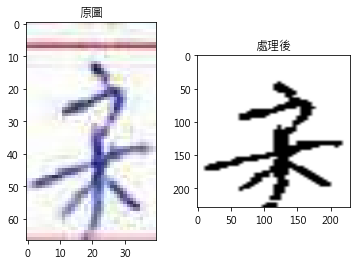

In [8]:
# label 字典
label_df = pd.read_csv('dict_df.csv')
# 讀圖並做前處理
img = cv2.imread(r'C:\Users\jason\Desktop\python\01_project\09_esun_2021\data-clean\0\1027.jpg')
img_pre = preproc_img(img)
# model input shape: (?, 229, 229, 3)
img_pre = img_pre.reshape(-1, 229, 229, 3)
# plt
pred_plt(img, img_pre, label_df)